# Import all the modules

In [25]:
# import modules for the detection of the particles 
from FIJI_Marco_For_Particle_Identification_V_stable import process_NF_particles as pnp
import glob
import multiprocessing as mp
import numpy as np 
import pandas as pd
import scipy.io as sio
import shutil
import time 
import gc
import os

In [26]:
# import plotting libraries 
from sklearn.neighbors import NearestNeighbors as nnbrs
import matplotlib.pyplot as plt
Big_color = '#F46D7D'
Small_color = '#9779f4'

In [27]:
# Do some particle detection
mainpath = r'C:\Users\lion\Desktop\PhD\Presentations\Vander Waals'
experimentPath = glob.glob(mainpath+'\*_files')
experimentPath

['C:\\Users\\lion\\Desktop\\PhD\\Presentations\\Vander Waals\\Image_Sequence_Dilute_Rollers_files']

In [28]:
# Do some particle detection
mainpath = r'C:\Users\lion\Desktop\PhD\Presentations\Vander Waals'
experimentPath = glob.glob(mainpath+'\*_files')
experimentPath

# parallelization code set
# add the Images 
experimentPath = [s + '\\Images\\' for s in experimentPath];
experimentPath = [s .replace('\\','/') for s in experimentPath];

results = [];
for Path in experimentPath:
    # ~~~~~~~~~~~ Count the total number of frames within the "Image" folder ~~~~~~~~~~~~~
    Total_Frames = len(glob.glob(Path +'*.tif'));
    if (os.path.normpath(glob.glob(Path +'*.tif')[-1]).split(os.sep)[-1] == 'ImageBackground.tif'):
        Total_Frames -= 1;
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # ~~~~~~~~~~~~ read the total number of images ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    N  = 2; # specify the number of workers ... do this judiciously  
    Ram_size = 30;
    memory_allocation = "-Xmx" + str(int (Ram_size/N)) + "g"; # N*memory alloc. not exceed the RAM size-1
    pool = mp.Pool(processes=N);
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #~~~~~~~~~~~~~~~~create the chunk firsts and lasts (tested robust) ~~~~~~~~~~~~~~~~~~~
    Chunk = (Total_Frames/N);
    frame_start = [];
    frame_finish =[];
    inp_for_starmap =[];

    for i in range(N):
        frame_start.append(int(np.floor(i*Chunk)+1));
        frame_finish.append(int(np.floor((i+1)*Chunk+1)));
        inp_for_starmap.append(tuple([Path,frame_start[i],frame_finish[i],memory_allocation]));

    #~~~~~~~~~~~~~create a "main" function for running the parallization code~~~~~~~~~~~~~
    #~~~~ the __main__ function is not necessary on mac and linux .. window 's crap!~~~~~~

    if __name__=="__main__":

        # ~~~~~~~~~~~~~~~~~~~ create a temporary folder in C: Drive ~~~~~~~~~~~~~~~~~~~~~~
        os.mkdir('C:/Temporary')

        start = time.perf_counter();    
        # creating N processes and executing them
        results = pool.starmap(pnp, inp_for_starmap);
        
        # convert every float64 to float32
        #for c in range(N):
        #    results[c][results[c].select_dtypes(np.float64).columns] = results[c].select_dtypes(np.float64).astype(np.float32);

        # measure the run time
        finish = time.perf_counter();

        # delete the temprorary folder in C: drive
        shutil.rmtree('C:/Temporary');
        
        # closing the pool is very important!! creates problem with multiple running 
        pool.close()

        print("time taken by",Path," is ", round((finish - start)/60),"minutes");

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/lion/Desktop/PhD/Presentations/Vander Waals/Image_Sequence_Dilute_Rollers_files/Analysis/1_Positions/Positions_NF.mat'

In [34]:
Final_array = pd.concat(results)
Final_array['I'] = np.zeros(len(Final_array))
Final_array['R'] = np.zeros(len(Final_array))

In [4]:
# write a function to devlop the arrows for the spins 
def vel_spins(frame1, frame2):
    counter_frame1 =[];
    for i in range(len(frame1.values)):
        counter_frame1.append(frame1.values[i][1:])
    frame1_train_data = np.array(counter_frame1) 

    counter_frame2 =[];
    for i in range(len(frame2.values)):
        counter_frame2.append(frame2.values[i][1:])
    frame2_train_data = np.array(counter_frame2)
    
    # find nearest neighbours 
    train_data = nnbrs(n_neighbors=1, algorithm='ball_tree')
    train_data.fit(frame1_train_data)
    _,indices = train_data.kneighbors(frame2_train_data)
    
    # match the positions
    add_X = []
    add_Y = []
    for x in indices:
        add_X.append(frame1.iloc[x]['X'])
        add_Y.append(frame1.iloc[x]['Y'])
        
    frame2['XX'] = np.array(add_X)
    frame2['YY'] = np.array(add_Y)  
    
    frame2['dX'] = frame2['XX'] - frame2['X']
    frame2['dY'] = frame2['YY'] - frame2['Y']
    frame2['dR'] = np.sqrt(frame2['dX']**2 + frame2['dY']**2)
    return frame2 

In [5]:
# read the data from the tsv files~~~~~~

# 1st frame 
F_data  = pd.read_csv(r'Trajectory\2F.tsv', sep = '\t')
NF_data  = pd.read_csv(r'Trajectory\2NF.tsv', sep = '\t')

# 2nd frame
F_data_2 = pd.read_csv(r'Trajectory\1F.tsv', sep='\t')
NF_data_2 = pd.read_csv(r'Trajectory\1NF.tsv', sep='\t')

# remove the extras  from F and NF particles
NF_data['R'] = np.sqrt((NF_data['X'] - 700)**2 + (NF_data['Y'] - 700)**2)
NF_Data_cropped = NF_data[NF_data['R']<630]
F_data['R'] = np.sqrt((F_data['X'] - 700)**2 + (F_data['Y'] - 700)**2)
F_Data_cropped = F_data[F_data['R']<650]


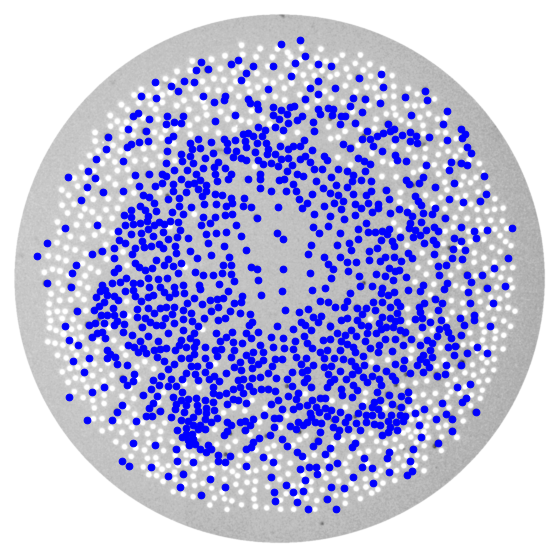

In [6]:
# plot only the Non-Fluorecent particles 
plt.figure(figsize = (10,10))
ax = plt.axes()
ax.axis('off')
#plt.scatter(F_Data_cropped['X'],F_Data_cropped['Y'],  s = 45, marker = 'o',c = Big_color)
plt.scatter(NF_Data_cropped['X'],NF_Data_cropped['Y'],s = 45, marker = 'o', c='b')
base_img = plt.imread('Base_image_1.tif')
plt.imshow(base_img, cmap = 'Greys_r')
plt.savefig('Small.png', dpi = 700, bbox_inches = 'tight')

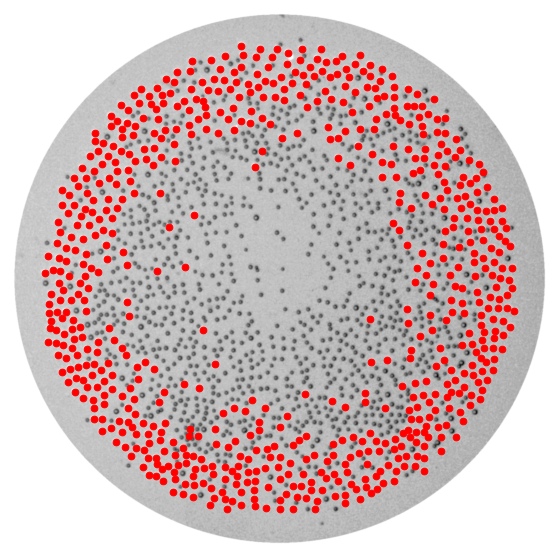

In [7]:
# plot the big particles 
plt.figure(figsize = (10,10))
ax = plt.axes()
ax.axis('off')
plt.scatter(F_Data_cropped['X'],F_Data_cropped['Y'],  s = 45, marker = 'o',c = 'r')
#plt.scatter(NF_Data_cropped['X'],NF_Data_cropped['Y'],s = 45, marker = 'o', c=Small_color)
base_img = plt.imread('Base_image_1.tif')
plt.imshow(base_img, cmap = 'Greys_r')
plt.savefig('Big.png', dpi = 700, bbox_inches = 'tight')

In [8]:
# Add the arrows 
# process Fluo arrows
F_data.drop(columns ='R', inplace = True)
arrowdata_F = vel_spins(F_data_2,F_data)
arrowdata_F.dropna()
arrowdata_F = arrowdata_F[arrowdata_F['dR']<40]
arrowdata_F = arrowdata_F[arrowdata_F['dR']>0]

# process Non - Fluo arrows
NF_data.drop(columns ='R', inplace = True)
arrowdata_NF = vel_spins(NF_data_2,NF_data)
arrowdata_NF.dropna()
arrowdata_NF = arrowdata_NF[arrowdata_NF['dR']<8]
arrowdata_NF = arrowdata_NF[arrowdata_NF['dR']>1]
arrowdata_NF['R'] = np.sqrt((arrowdata_NF['X']-704)**2 + (arrowdata_NF['Y']-704)**2)
arrowdata_NF = arrowdata_NF[arrowdata_NF['R']<650]

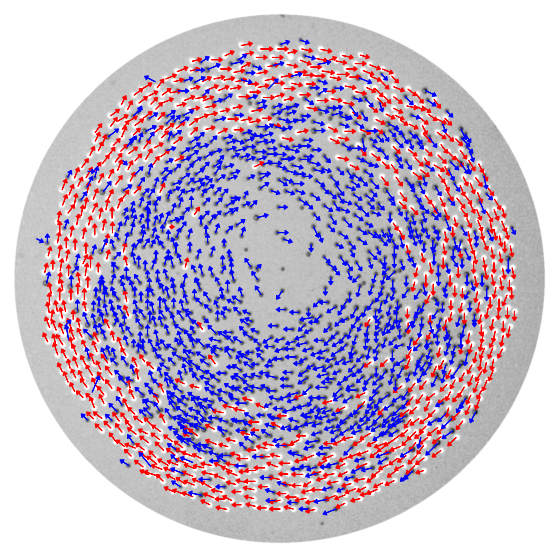

In [39]:
# # Plot the PTV ~~~~~~~~~~~~~
plt.figure(figsize = (10,10))
ax = plt.axes()
ax.axis('off')
#plt.scatter(F_Data_cropped['X'],F_Data_cropped['Y'],  s = 45, marker = 'o',c = Big_color)
#plt.scatter(NF_Data_cropped['X'],NF_Data_cropped['Y'],s = 45, marker = 'o', c=Small_color)
base_img = plt.imread('Base_image_1.tif')
plt.imshow(base_img, cmap = 'Greys_r')

# plot the arrows F
for i in range(0,len(arrowdata_F)):
    plt.arrow(arrowdata_F.iloc[i]['X'],arrowdata_F.iloc[i]['Y'],-arrowdata_F.iloc[i]['dX']*4,
              -arrowdata_F.iloc[i]['dY']*4, head_width=12, head_length=9, color = 'r')
# plot the arrows NF
for i in range(0,len(arrowdata_NF)):
    plt.arrow(arrowdata_NF.iloc[i]['X'],arrowdata_NF.iloc[i]['Y'],-arrowdata_NF.iloc[i]['dX']*5,
              -arrowdata_NF.iloc[i]['dY']*5, head_width=12, head_length=9, color = 'b', width= 0.3)
plt.savefig(r'C:\Users\lion\Dropbox\Adobe\PTV.png', dpi = 700, bbox_inches = 'tight')